# simulating minimal particle exclusion model
Tim Tyree<br>
10.19.2023

In [4]:
#automating the boring stuff may take ~20 seconds to initialize here...
from lib import *
%load_ext autoreload
%autoreload 2

plt.plot([4]*3)
plt.close()
#reset matplotlib
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()
#set randomization seed
np.random.seed(42)
#consider darkmode
darkmode=False
if darkmode:
    # For darkplmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

from numba import njit

import scipy.stats as stats
from scipy.stats import f_oneway
#reset matplotlib
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()
#set randomization seed
np.random.seed(42)
#consider darkmode
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# define module

In [41]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [39]:
def seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=1000):
    """
    Example Usage:
xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100)
    """
    xg=np.random.uniform(0,1)*L
    yg=np.random.uniform(0,1)*L
    mindist=2.*L
    for j in np.argwhere(still_running).flatten():
        dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
        if dist<mindist:
            mindist=dist
    #while new particle is within distance R_c_bar from any other particle
    num=0
    while (mindist<R_c_bar) and (num<max_num_retries):
        num+=1
        xg=np.random.uniform(0,1)*L
        yg=np.random.uniform(0,1)*L
        mindist=2.*L
        for j in np.argwhere(still_running).flatten():
            dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
            if dist<mindist:
                mindist=dist
    return xg,yg

def  gener_termination_time(seed,Ninitial=2,Nfinal=0,
                            chi=2.08,
                            R_c_bar=0.6667, #cm
                            kappa=75, #Hz
                            r=0.314, #cm 
                            varkappa=9.3, #cm^2/s
                            D=0.42, #cm^2/s
                            Mp = 3.28, #+/- 0.10 Hz/cm^2;
                            nup = 0.715, #+/- 0.010
                            r0=0.202,
                            L=5,
                            creation_duration = 0.1, #s 0.0025, # 0.001 #s  # 
                            Dt=1e-5,dt=1e-5,
                            no_repulsion=0,no_attraction=0,
                            save_every=5,
                            tmax=60, #s
                            epsilon=5e-2,  #reactions happen immediately at this range
                            x0=5,  #skipping reflect,set_second, and neighbor functionality
                            N=150, #max number of particles
                            force_code=2,
                            dist_cutoff=1e-2,
                            use_creation=True,
                            use_pair_create=True,
                            use_set_created_from_existing=True,
                            use_uniform_ic=False,
                            show_movie=False,#True,
                            recording_locations=False,#True,
                            recording_snapshots=False,#True,
                            printing=False,
                          **kwargs):
    """
    Example Usage:
t = gener_termination_time(seed,Ninitial=2,Nfinal=0,
                            chi=chi,kappa=kappa, #Hz
                            r=r, #cm 
                            varkappa=varkappa, #cm^2/s
                            D=D, #cm^2/s
                            Mp = Mp, # Hz/cm^2;
                            nup = nup,L=L,creation_duration = creation_duration, # 0.001 #s  # 0.1 #s
                            Dt=Dt,dt=dt,use_creation=True,use_pair_create=True,use_set_created_from_existing=True)
print(f"termination time: {t}")
    """
#     r0=r
#     r0=6e-2
#     tmax=500 #s
#     tmax=60 #s
#     epsilon=5e-2  #reactions happen immediately at this range
#     x0=5
#     #skipping reflect,set_second, and neighbor functionality
#     N=150 #max number of particles
    np.random.seed(seed)            
    x_values=np.random.uniform(0,1,size=N)*L
    y_values=np.random.uniform(0,1,size=N)*L
    t=0
    if use_uniform_ic:
        Nrow=4
    #     Nrow=10
        #explicitely uniform ic.
        uvals=np.linspace(0,L*Nrow/(Nrow+1),Nrow)
        x_values,y_values=np.meshgrid(uvals,uvals)
        x_values=x_values.flatten()+L/(2*(Nrow+1))
        y_values=y_values.flatten()+L/(2*(Nrow+1))
        #explicitely enter ^these values in my c simulation and run it
        N = x_values.shape[0]
        
    #return a scatter plot that may be saved as png
    if show_movie:
        annotating=True
        message='initial positions'
        fig=ScatterPlotSnapshot(x_values,y_values,t,width=L,height=L,
                                annotating=annotating,message=message,inch=6)
        plt.show()

    if show_movie:
        #for snapshot output
        save_folder=f"{nb_dir}/Figures/mov"
        if os.path.exists(save_folder):
            #cleanse the old snapshot folder
            shutil.rmtree(save_folder)
        os.mkdir(save_folder)
        frameno=1
        save_fn=None
        inch=6
        annotating=True

#     # message='without forces'
#     # force_code=0
#     # varkappa=0
#     # message='with anti-spring forces'
#     # force_code=1
#     # varkappa=-5
# #     message='with particle creation'
#     force_code=2    
#     dist_cutoff=1e-2
    
    # varkappa=1.552
    # message=f'with {alpha=}'
    message=' '
    stepscale=np.sqrt(2*D*Dt) #diffusive
    # stepscale=(2*D*Dt)**(1/alpha)
    probreact=kappa*dt
    A = L**2
    T_net=0;count_net=0    
    # iter_per_movestep = round(Dt/dt)
    impulse_prefactor= varkappa * Dt
    tiarray=np.zeros(N)
    tfarray=np.zeros(N)
    step=0
    if printing:
        print("running simulation...");
    t=-Dt
    # still_running=True;
    exit_code=-1;T=-9999.
    #initialize positions
    # #uniform random ic
    # x_values=rs.uniform(size=N)*L
    # y_values=rs.uniform(size=N)*L
    # #explicitely uniform ic
    # uvals=np.linspace(0,L,5)
    # x_values,y_values=np.meshgrid(uvals,uvals)
    # x_values=x_values.flatten()
    # y_values=y_values.flatten()

    #lower case: world coordinates
    #upper case: material coordinates
#     x=x_values.copy()
#     y=y_values.copy()
    x_old=x_values.copy()
    y_old=y_values.copy()
    x_new=x_values.copy()
    y_new=y_values.copy()
#     X=x_values.copy()
#     Y=y_values.copy()
#     X_old=x_values.copy()
#     Y_old=y_values.copy()
#     X_new=x_values.copy()
#     Y_new=y_values.copy()
    
    
    
    
    zeros=np.zeros_like(x_values)
    zerosint=np.zeros_like(x_values).astype('int')
    # still_running=zerosint==zerosint
    still_running=zerosint!=zerosint
#     still_running[:Ninitial]=True  #initialize first Ninitial particles to still be running
    caught=zerosint.copy()-9999#!=zerosint
    anticaught=zerosint.copy()-9999#!=zerosint
    
    #create the initial particles
    for i in range(Ninitial):
        xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100)
        x_new[i]=xg
        y_new[i]=yg
        still_running[i]=True    
    
    # //start set_second kernel
    # //end set_second kernel
    #make still_running into still_running_values
    dict_out_lst=[]
    # reset the net forces
    Fx_net=zeros.copy()
    Fy_net=zeros.copy()
    # while(still_running.any()):
    while(still_running.sum()>Nfinal):
        # //reinitialize_kernel, which copies X,Y_new to X,Y_old
        min_dist_old=zeros+9999999
        i_neighbor=zerosint-1
        x_old=x_new
        y_old=y_new
        t=t+Dt;
#         np.random.seed(seed) # didn't make it deterministic

        #sum_each_force_kernel
        for i in range(N):
            if(still_running[i]):
                for j in range(i+1,N):
                    if(still_running[j]):
                        #compute displacement vector with pbc
                        dx = subtract_pbc_1d(x_old[j],x_old[i],L);
                        dy = subtract_pbc_1d(y_old[j],y_old[i],L);
                        dist2=dx*dx+dy*dy;
                        if (dist2<1e-8):
                            dist2=float(1e-8)
                        dist = np.sqrt(dist2)
                        #compute displacement due to drift
                        impulse_factor=0.
                        if (force_code==1):
                          #spring
                          impulse_factor=impulse_prefactor*(dist-x0)/dist;
                        if (force_code==2):
                          #QED2: force ~ inverse power law
                          impulse_factor=impulse_prefactor/dist2;
                        if (force_code==3):
                          #QED3: force ~ inverse square power law
                          impulse_factor=impulse_prefactor/dist2/dist;
                        #set impulse_factor to zero if it is explicitly forbidden by the user input
                        if ((no_attraction==1) & (impulse_factor>0)):
                            impulse_factor=0.
                        if ((no_repulsion==1) & (impulse_factor<0)):
                            impulse_factor=0.
                        #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
                        Fx_net[i]=Fx_net[i]+dx*impulse_factor;
                        Fy_net[i]=Fy_net[i]+dy*impulse_factor;
                        Fx_net[j]=Fx_net[j]-dx*impulse_factor;
                        Fy_net[j]=Fy_net[j]-dy*impulse_factor                    
                        #determine if they are closer than epsilon
                        if dist<epsilon:
                            #remove if they are
                            still_running[i]=False
                            still_running[j]=False
                            uncatch_set=set()
                            if caught[i]>=0: 
                                uncatch_set.update([caught[i]])
                                if caught[caught[i]]>=0:
                                    uncatch_set.update([caught[caught[i]]])
                            if caught[j]>=0: 
                                uncatch_set.update([caught[j]])
                                if caught[caught[j]]>=0:
                                    uncatch_set.update([caught[caught[j]]])
                            if len(uncatch_set)>0:
                                for k in uncatch_set:
                                    caught[k]=-9999
        #compute the one_step given the net force, F_net
        for i in range(N):
            if(still_running[i]):
                if caught[i]<0:
                    dxt=Fx_net[i];
                    dyt=Fy_net[i];
                    # compute displacement due to levy flight
    #                 dxW,dyW = stepscale*levyRandom2D(alpha)
#                     dxW = stepscale*normalRandom()
#                     dyW = stepscale*normalRandom()
                    dxW = stepscale*np.random.normal()
                    dyW = stepscale*np.random.normal()
                    # next spatial position, time integrating by a duration, Dt. enforce PBC.
                    x_new[i]=periodic(x_old[i]+dxW+dxt,L);
                    y_new[i]=periodic(y_old[i]+dyW+dyt,L);
                else:
                    j=caught[i]
                    ti=tiarray[i]
                    tf=tfarray[i]            
                    #compute displacement vector with pbc
                    dx = subtract_pbc_1d(x_old[j],x_old[i],L)
                    dy = subtract_pbc_1d(y_old[j],y_old[i],L)      
                    xl = dx - (x_old[j]-x_old[i])
                    yl = dy - (y_old[j]-y_old[i])
                    #compute average location
                    xavg = x_old[i] + 0.5*dx 
                    yavg = y_old[i] + 0.5*dy
                    #compute frac to interpolate by
                    frac = (t-ti)/(tf-ti)
                    frac = np.min((1,frac))
                    x_new[i] = periodic(x_old[i]*(1-frac) + (xavg+xl)*frac,L)
                    y_new[i] = periodic(y_old[i]*(1-frac) + (yavg+yl)*frac,L)
        #reaction_kernel
        for i in range(N):
            if(still_running[i]&(caught[i]<0)&(anticaught[i]<0)):
                # // each i,j pair is reached once per call to kernel_measure
                for j in range(i+1,N):
                    if(still_running[j]&(caught[j]<0)&(anticaught[j]<0)):
                        # // compute distance between particles that are still running
                        dist=dist_pbc(x_new[i],y_new[i],x_new[j],y_new[j],L);
                        in_range=dist<r;
                        # // in_range=true;//uncomment for smeared method
                        # // if two particles are in range
                        if(in_range):
                            # // determine whether those two particles react via the simple method
#                             reacts=probreact>uniformRandom();
                            reacts=probreact>np.random.uniform(0,1);
                            # // determine whether those two particles react via the smeared method
                            # // sig=sigmoid(dist, r, beta);
                            # // reacts=probreact*sig>uniformRandom();
                            if(reacts):
                                exit_code=1;
                                T=t;
    #                             still_running[i]=False;
    #                             still_running[j]=False;
                                #uncatch any previous catches
                                if caught[i]>=0: caught[caught[i]]=-9999
                                if caught[j]>=0: caught[caught[j]]=-9999
                                #catch these two
                                caught[i]=j;
                                caught[j]=i;
                                #determine deltat
                                deltat = dist**2/(4*(varkappa+2*D))
                                #determine ti,tf
                                tiarray[i]=t
                                tfarray[i]=t+deltat
                                tiarray[j]=t
                                tfarray[j]=t+deltat

        #determine rate_of_creation from average density
        num_particles = np.sum(still_running)
        prob_create = dt * Mp * (num_particles / A) ** nup * A
        #creation_kernel
        if not use_creation:
            prob_create=0 
        if prob_create>np.random.uniform(0,1):
            if np.sum(~still_running)>=2:
                #select the first two particles that are removed
                igone=np.argwhere(~still_running)
                #reset/set their internal state
                caught[igone[0]]=-9999
                caught[igone[1]]=-9999
                anticaught[igone[0]]=igone[1]
                anticaught[igone[1]]=igone[0]
                tfarray[igone[0]]=t+creation_duration
                tfarray[igone[1]]=t+creation_duration
                
#                 #set their positions to 2 uniformly distributed positions
#                 x_new[igone[0]]=np.random.uniform(0,1)*L
#                 x_new[igone[1]]=np.random.uniform(0,1)*L
#                 y_new[igone[0]]=np.random.uniform(0,1)*L
#                 y_new[igone[1]]=np.random.uniform(0,1)*L
                
                #check if new particle is within distance R_c_bar from any other particles
                for ihere in igone[:2]:
                    xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=1000)
                    x_new[ihere]=xg
                    y_new[ihere]=yg
                    still_running[ihere]=True
            
                #optionally set their positions to average a random location
                if use_pair_create:
                    #optionally set their positions be a fixed distance to nearest tip
                    if use_set_created_from_existing:
                        #place a pair of particles uniformly on the circle of radius R_c_bar from a random particle
                        xg,yg=gener_random_creation_position(x_new,y_new,still_running,R_c_bar,L)
                        x_new[igone[0]] = xg
                        y_new[igone[0]] = yg
                    theta=2*np.pi*np.random.uniform(0,1)
                    #heretim
                    x_new[igone[1]]=x_new[igone[0]] + 2.*r0*np.cos(theta)
                    y_new[igone[1]]=y_new[igone[0]] + 2.*r0*np.sin(theta)


        # reset the net forces
        Fx_net=zeros.copy()
        Fy_net=zeros.copy()
        #creation_force_kernel
        if use_pair_create:
            for i in range(N):
                if(still_running[i]&(anticaught[i]>=0)):
                    j = anticaught[i]
                    if still_running[j]:
                        #compute displacement vector with pbc
                        dx = subtract_pbc_1d(x_old[j],x_old[i],L);
                        dy = subtract_pbc_1d(y_old[j],y_old[i],L);
                        dist2=dx*dx+dy*dy;
                        if (dist2<1e-8):
                            dist2=float(1e-8)
                        dist = np.sqrt(dist2)
                        #compute displacement due to drift
                        impulse_factor=0.
                        if (force_code==1):
                          #spring
                          impulse_factor=impulse_prefactor*(dist-x0)/dist;
                        if (force_code==2):
                          #QED2: force ~ inverse power law
                          impulse_factor=impulse_prefactor/dist2;
                        if (force_code==3):
                          #QED3: force ~ inverse square power law
                          impulse_factor=impulse_prefactor/dist2/dist;
                        #set impulse_factor to zero if it is explicitly forbidden by the user input
                        if ((no_attraction==1) & (impulse_factor<0)):
                            impulse_factor=0.
                        if ((no_repulsion==1) & (impulse_factor>0)):
                            impulse_factor=0.
                        #account for double counting and then scale
                        impulse_factor*=0.5*chi
                        #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
                        Fx_net[i]=Fx_net[i]-dx*impulse_factor;
                        Fy_net[i]=Fy_net[i]-dy*impulse_factor;
                        Fx_net[j]=Fx_net[j]+dx*impulse_factor;
                        Fy_net[j]=Fy_net[j]+dy*impulse_factor 

        #turn off creation array
        for i in range(N):
            if still_running[i] and anticaught[i]>=0:
                if t>tfarray[i]:
                    anticaught[i]=-9999

        if show_movie:
            if step%save_every==0:
                x_plot=x_new[still_running]
                y_plot=y_new[still_running]
                c_plot = np.array(['gray']*y_plot.shape[0])
                caugh=caught[still_running]
                for i in range(y_plot.shape[0]):
                    if caugh[i]>=0:
                        c_plot[i]='r'
                acaugh=anticaught[still_running]
                for i in range(y_plot.shape[0]):
                    if acaugh[i]>=0:
                        c_plot[i]='g'

                if recording_snapshots:
                    #save result as png
                    SaveScatterPlotSnapshot(x_plot,y_plot,t,
                                            c=c_plot,
                                            width=L,height=L,
                                    frameno=frameno,save_folder=save_folder,
                                    annotating=annotating,message=message)
        #             print(f"- saved pic at {frameno=}")
                if (recording_locations)&(x_plot.shape[0]>0):
                    pid_values = np.arange(x_values.shape[0])[still_running]
                    #append particle locations to log, dict_out_lst
                    dict_out=format_particles(frameno,t,x_plot,y_plot,pid_values=pid_values)
                    dict_out_lst.append(dict_out)

                frameno+=1

        #shut simulation down if it's taking too long...
        if (t>tmax):
            for i in range(N):
                still_running[i]=False;
                exit_code=-99;

        step+=1
        #end while running

    #record this trial
    if (exit_code>0):
        if (T>0.):
            T_net=T_net+T;
            count_net=count_net+1;

    if printing:
        print(f"simulation complete!")
        beep(1)

    if recording_locations:
        #for csv output
        data_folder=f"{nb_dir}/data/local_results/creation_test_paired"
        if not os.path.exists(data_folder):
            os.mkdir(data_folder)
        data_folder=data_folder+"/Log"
        if not os.path.exists(data_folder):
            os.mkdir(data_folder)
#         data_fn=f"pbc_seed_{seed}_fc_{force_code}_r_{r}_D_{D}_L_{L}_kappa_{kappa}_varkappa_{varkappa}_alpha_{alpha}_creatdur_{creation_duration}_chi_{chi}_log.csv"
        data_fn=f"pbc_seed_{seed}_fc_{force_code}_r_{r}_D_{D}_L_{L}_kappa_{kappa}_varkappa_{varkappa}_creatdur_{creation_duration}_chi_{chi}_log.csv"
        
    #save particle locations as csv
    if recording_locations:
        df = pd.concat([pd.DataFrame(dict_out) for dict_out in dict_out_lst])
        df.reset_index(inplace=True, drop=True)
        #save the recorded data
        os.chdir(data_folder)
        df.to_csv(data_fn, index=False)
        if printing:
            print('saved to:')
            print(os.path.abspath(data_fn))
        
    return t

In [100]:
@njit
def gener_inrange_lst(x_values,y_values,r,L):
    """identify any particle pair that is within distance r of one another

    Example Usage:
inrange_lst = gener_inrange_lst(x_values,y_values,r,L)
    """
    N=x_values.shape[0]
    inrange_lst=[]
    for i in range(N):
        for j in range(i+1,N):
            dist=dist_pbc(x1=x_values[i], 
                     y1=y_values[i], 
                     x2=x_values[j], 
                     y2=y_values[j], 
                     L=L)
            if dist<r:
#                 inrange_lst.append(np.array((i,j)))
                inrange_lst.append((i,j))
    return inrange_lst

@njit
def gener_colliding_values(N_values,r,L,seed):
    """
    Example Usage:
num_particles_values,num_colliding_values = gener_colliding_values(N_values,r,L,seed)
    """
    np.random.seed(seed)
    num_colliding_values=np.zeros_like(N_values)
    num_particles_values=np.zeros_like(N_values)
    #for each particle number
    for i,N in enumerate(N_values):
        #seed particle locations
        x_values = np.random.uniform(0,L,N)
        y_values = np.random.uniform(0,L,N)
        #identify any particle pair that is within distance r of one another
        inrange_lst = gener_inrange_lst(x_values,y_values,r,L)
        num_colliding = len(inrange_lst)
        # counts,_=np.histogram(np.concatenate(inrange_lst),bins=range(N))
        # indices_sorted = np.argsort(counts)[::-1]
        # # counts[indices_sorted]
        if num_colliding>0:
#             num_particles=N - np.unique(np.concatenate(inrange_lst)).shape[0]
            lst=[]
            for x in inrange_lst:
                lst.extend(x)
            num_particles=N - np.unique(np.array(lst)).shape[0]
        else:
            num_particles=N
        #record
        num_particles_values[i]=num_particles
        num_colliding_values[i]=num_colliding
    return num_particles_values,num_colliding_values

# TODO(later): show mean initial number of particles plateaus for sufficiently large $N$, 
as is shown by Fig. \ref{fig:1}A.  Here, the y-axis shows the mean number of particles while the shaded region shows the estimated 95\% confidence intervals of the mean in units of the quantity, $\pi r^2/L^2$.

In [166]:
# at $L=5$ cm and $r=0.25$ cm
L=5 #cm
r=0.25 #cm
# r=2.5

In [167]:
np.random.seed(42)
num_samples=10000000
num_samples=1
for trial_num in range(num_samples):
    pass
#for each particle number
N_values = np.arange(1,1000)
num_particles_values,num_colliding_values = gener_colliding_values(N_values,r,L,seed=42)

In [168]:
num_particles_values,num_colliding_values = gener_colliding_values(N_values,r,L,seed=1)
navg=30
Nmax = np.max(moving_average(num_particles_values,navg))
N0max=moving_average(N_values,navg)[np.argmax(moving_average(num_particles_values,navg))]
N0max

138.5

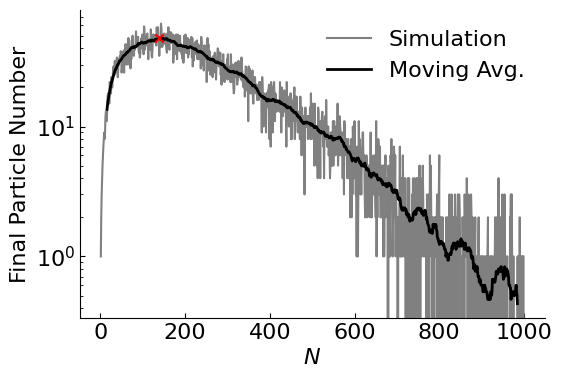

-n 
-n 
-n 
N0max=138.5
Nmax=48.166666666666664


In [170]:
fig,ax=plt.subplots(figsize=(6,4))
# plt.plot(num_particles_values,num_colliding_values)
plt.plot(N_values,num_particles_values,'gray',label='Simulation')
plt.plot(moving_average(N_values,navg),
         moving_average(num_particles_values,navg),'k',label='Moving Avg.',lw=2)
plt.scatter([N0max],[Nmax],marker='x',color='r',zorder=3)
# format_plot(fontsize=16,xlabel='Initial Particle Number',ylabel='Number Particles Remaining')
format_plot(fontsize=16,xlabel=r'$N$',ylabel='Final Particle Number')
plt.legend(fontsize=16,frameon=False)
plt.tick_params(top=False, right=False,direction='in',which='both')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.yscale('log')
plt.show()
beep(3)
print(f"{N0max=}")
print(f"{Nmax=}")

In [162]:
navg=30
seed=1
L=1
r_values=np.arange(0.05,0.56,0.01)
r_values=np.logspace(-2,0,100)
Nmax_values=np.zeros_like(r_values)
N0max_values=np.zeros_like(r_values)
for i,r in enumerate(r_values):
    num_particles_values,num_colliding_values = gener_colliding_values(N_values,r,L,seed=seed)
    Nmax = np.max(moving_average(num_particles_values,navg))
    N0max=moving_average(N_values,navg)[np.argmax(moving_average(num_particles_values,navg))]
    #record
    Nmax_values[i]=Nmax
    N0max_values[i]=N0max
    seed+=1

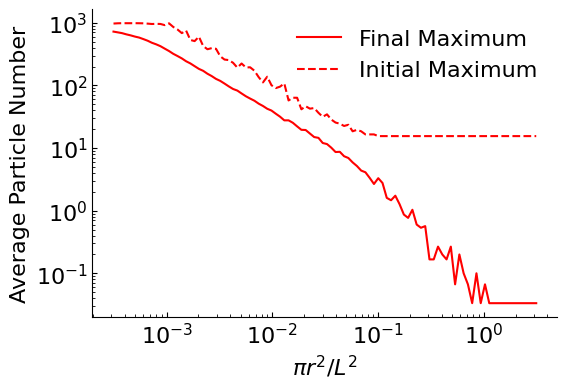

-n 
-n 
-n 
Nmax=0.03333333333333333


In [163]:
fig,ax=plt.subplots(figsize=(6,4))
# plt.plot(num_particles_values,num_colliding_values)
plt.plot(np.pi*(r_values/L)**2,Nmax_values,color='r',label='Final Maximum')
plt.plot(np.pi*(r_values/L)**2,N0max_values,color='r',linestyle='--',label='Initial Maximum')
# plt.plot(moving_average(N_values,navg),
#          moving_average(num_particles_values,navg),'k',label='Moving Avg.',lw=2)
# plt.scatter([N0max],[Nmax],marker='x',color='r',zorder=3)
# format_plot(fontsize=16,xlabel='Initial Particle Number',ylabel='Number Particles Remaining')
format_plot(fontsize=16,xlabel=r'$\pi r^2/L^2$',ylabel='Average Particle Number')
plt.legend(fontsize=16,frameon=False,loc='upper right')
plt.tick_params(top=False, right=False,direction='in',which='both')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xscale('log')
plt.yscale('log')
plt.show()
beep(3)
print(f"{Nmax=}")

In [164]:
L=1
np.sqrt(L**2/np.pi)

0.5641895835477563

# DONE: define the particle model of creation

# DONE: generate mean termination time versus initial number of particles, $N$